<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/schools8_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit a hierarchical Bayesian model to the "8 schools" dataset.
See also https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

In [1]:
%matplotlib inline
import jax
import jax.numpy as jnp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [2]:
# !pip install -qq -U pymc3>=3.8
try:
    import blackjax
except ModuleNotFoundError:
    %pip install -qq blackjax
    import blackjax
try:
    import pymc3 as pm
except ModuleNotFoundError:
    %pip install -qq pymc3
    import pymc3 as pm
print(pm.__version__)
try:
    import theano.tensor as tt
except ModuleNotFoundError:
    %pip install -qq theano
    import theano.tensor as tt
import theano

try:
    from probml_utils import latexify
    from probml_utils.blackjax_utils import inference_loop_multiple_chains, arviz_trace_from_states, inference_loop
except:
    %pip install -qq git+https://github.com/probml/probml-utils.git
#!pip install -qq arviz
try:
    import arviz as az
except ModuleNotFoundError:
    %pip install -qq arviz
    import arviz as az
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions

3.11.5


2022-07-05 13:57:41.938103: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [3]:
!mkdir ../figures

mkdir: cannot create directory ‘../figures’: File exists


# Data

8.75
7.5


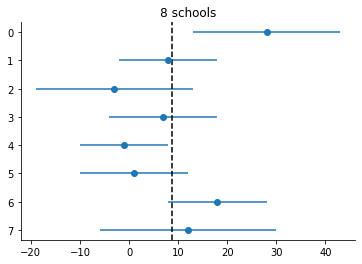

In [51]:
# https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

# Data of the Eight Schools Model
J = 8
treatment_effects = jnp.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
treatment_stddevs = jnp.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])
names = []
for t in range(8):
    names.append("{}".format(t))

# Plot raw data
fig, ax = plt.subplots()
y_pos = jnp.arange(8)
ax.errorbar(treatment_effects, y_pos, xerr=treatment_stddevs, fmt="o")
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.axvline(jnp.mean(treatment_effects), color="k", linestyle="--")

plt.title("8 schools")
sns.despine()
plt.savefig("../figures/schools8_data.png")
plt.show()

# Centered model

In [61]:
# define the
mu_prior = tfd.Normal(loc=0, scale=5)
sigma_prior = tfd.HalfCauchy(loc=0, scale=5)


def log_post_fn_centered(params):
    mu, tou, theta = params["mu"], params["tou"], params["theta"].reshape((-1,))
    log_prior_mu = mu_prior.log_prob(mu)
    log_prior_tou = sigma_prior.log_prob(tou)
    log_prior_theta = jnp.sum(tfd.Normal(mu, tou).log_prob(theta))
    log_like = 0
    log_like += jnp.sum(tfd.Normal(theta, treatment_stddevs).log_prob(treatment_effects))
    return log_like + log_prior_mu + log_prior_theta + log_prior_tou

In [62]:
num_samples = 10_000
num_chains = 4
num_warmup = 25_000

In [63]:
key = jax.random.PRNGKey(311)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

In [64]:
num_chains = 4
keys_warmup = jax.random.split(key_warmup, 4)
mu_inital = mu_prior.sample(seed=key_init, sample_shape=num_chains)
sigma_initial = sigma_prior.sample(seed=key_init, sample_shape=num_chains)
theta_initial = tfd.Normal(loc=mu_inital, scale=sigma_initial).sample(seed=key_init, sample_shape=8).T
params_centerd = {
    "mu": mu_inital,
    "tou": sigma_initial,
    "theta": theta_initial,
}

In [9]:
params_centerd_one = {"mu": mu_inital[0], "tou": sigma_initial[0], "theta": theta_initial[0]}

In [11]:
adapt = blackjax.window_adaptation(blackjax.nuts, log_post_fn_centered, num_warmup)
final_states_cent = jax.vmap(lambda key, param: adapt.run(key, param)[0])(keys_warmup, params_centerd)
final_state, kernel, _ = adapt.run(keys_warmup[1], params_centerd_one)
states_cent, infos_cent = inference_loop_multiple_chains(
    key_samples, kernel, final_states_cent, num_samples, num_chains
)

In [12]:
infos_cent.is_divergent.sum(axis=0)

DeviceArray([3098, 1608, 1977, 2298], dtype=int32)

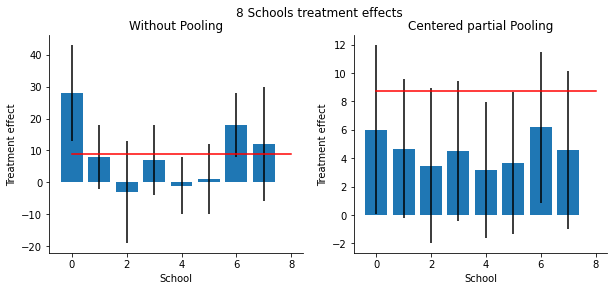

In [52]:
num_schools = 8
thetas_cent = states_cent.position["theta"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(
    range(num_schools),
    jnp.mean(jnp.mean(thetas_cent[:, :], axis=0), axis=0),
    yerr=jnp.mean(jnp.std(thetas_cent[:, :], axis=0), axis=0),
)
ax1.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax2.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("Centered partial Pooling")
sns.despine()
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()

In [14]:
def arviz_trace_from_states(states, info, burn_in=0):
    """
    args:
    ...........
    states: contains samples returned by blackjax model (i.e HMCState)
    info: conatins the meta info returned by blackjax model (i.e HMCinfo)

    returns:
    ...........
    trace: arviz trace object
    """
    if isinstance(states.position, jnp.DeviceArray):  # if states.position is array of samples
        samples = {"samples": jnp.swapaxes(states.position, 0, 1)}
        divergence = jnp.swapaxes(info.is_divergent, 0, 1)

    else:  # if states.position is dict
        samples = {}
        for param in states.position.keys():
            ndims = len(states.position[param].shape)
            if ndims > 1:
                samples[param] = jnp.swapaxes(states.position[param], 0, 1)[:, burn_in:]  # swap n_samples and n_chains
                divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

            if ndims == 1:
                divergence = info.is_divergent
                samples[param] = states.position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data({"diverging": divergence}, group="sample_stats")
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

In [15]:
trace_centered = arviz_trace_from_states(states_cent, infos_cent)
az.plot_trace(trace_centered);

In [17]:
az.summary(trace_centered)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,4.051,3.324,-2.142,10.483,0.104,0.074,1010.0,614.0,1.01
theta[0],6.022,5.940,-4.109,17.647,0.161,0.114,1080.0,1267.0,1.01
theta[1],4.658,4.904,-4.295,14.303,0.105,0.074,1853.0,6076.0,1.01
theta[2],3.480,5.445,-6.766,13.950,0.090,0.066,2768.0,8820.0,1.01
theta[3],4.506,4.907,-4.634,14.081,0.107,0.075,1845.0,8271.0,1.01
theta[4],3.169,4.759,-5.795,12.223,0.091,0.068,2362.0,6493.0,1.00
theta[5],3.673,4.979,-5.866,13.170,0.094,0.070,2387.0,8636.0,1.00
theta[6],6.187,5.336,-2.804,16.735,0.176,0.124,779.0,822.0,1.01
theta[7],4.556,5.570,-5.227,15.702,0.116,0.082,1810.0,8622.0,1.01
tou,3.990,3.271,0.466,9.779,0.114,0.081,198.0,59.0,1.03


In [18]:
# Display the total number and percentage of divergent chains
print("Number of Divergent Chains: {}".format(infos_cent.is_divergent.sum()))
diverging_pct = infos_cent.is_divergent.sum() / (num_samples * num_chains) * 100
print("Percentage of Divergent Chains: {:.1f}".format(diverging_pct))

Number of Divergent Chains: 8981
Percentage of Divergent Chains: 22.5


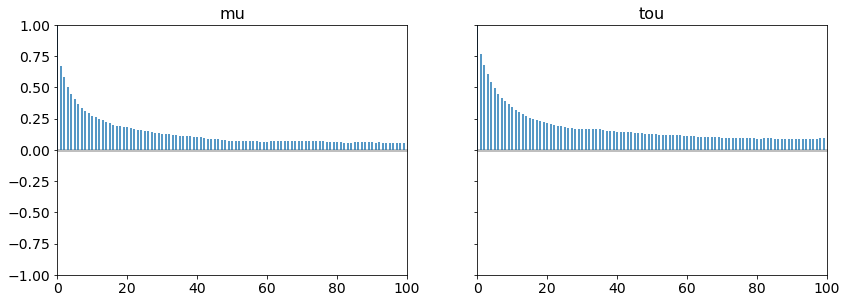

In [19]:
az.plot_autocorr(trace_centered, var_names=["mu", "tou"], combined=True)
plt.savefig("schools8_centered_acf_combined.png", dpi=300)

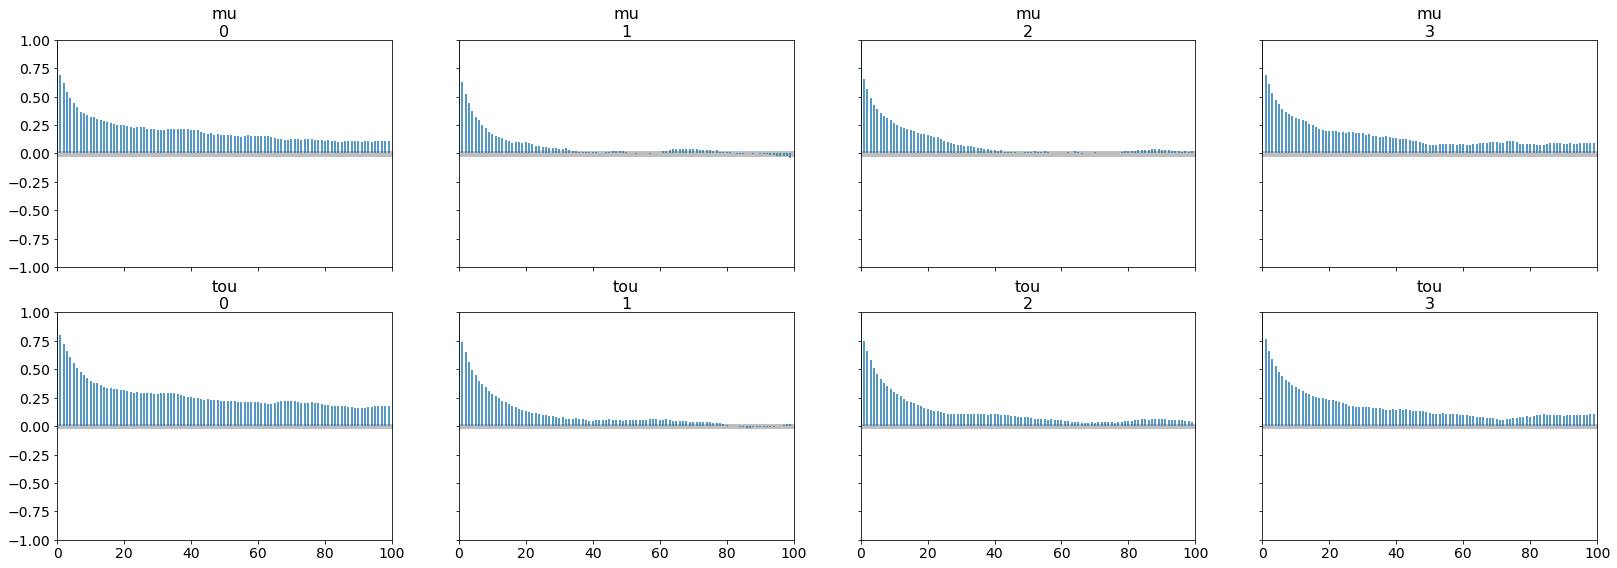

In [20]:
az.plot_autocorr(trace_centered, var_names=["mu", "tou"])
plt.savefig("schools8_centered_acf.png", dpi=300)

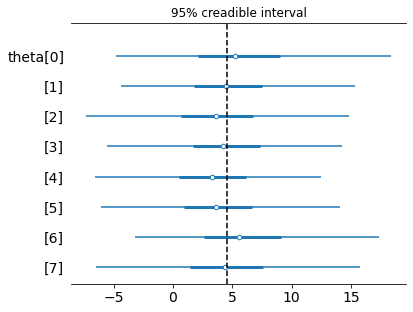

In [50]:
# with Centered_eight:
az.plot_forest(trace_centered, var_names="theta", hdi_prob=0.95, combined=True)
plt.axvline(jnp.mean(states_cent.position["theta"].mean()), color="k", linestyle="--")
plt.title("95% creadible interval")
plt.savefig("schools8_centered_forest_combined.png", dpi=300)

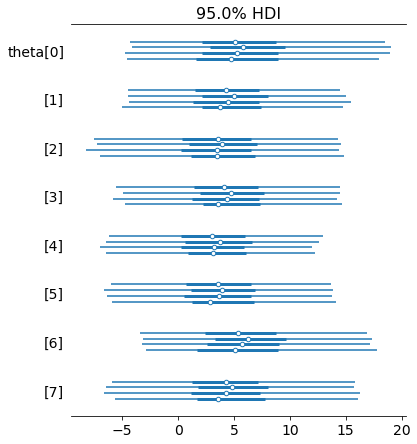

In [22]:
# with Centered_eight:
az.plot_forest(trace_centered, var_names="theta", hdi_prob=0.95, combined=False)
plt.savefig("schools8_centered_forest.png", dpi=300)

# Non-centered

In [23]:
mu_prior = tfd.Normal(loc=0, scale=5)
sigma_prior = tfd.HalfCauchy(loc=0, scale=5)


def log_post_fn_non_centered(params):
    mu, tou, eta = params["mu"], params["tou"], params["eta"]
    log_prior_mu = mu_prior.log_prob(mu)
    log_prior_tou = sigma_prior.log_prob(tou)
    log_prior_eta = jnp.sum(tfd.Normal(0, 1).log_prob(eta))
    log_like = 0
    log_like += jnp.sum(tfd.Normal(mu + tou * eta, treatment_stddevs).log_prob(treatment_effects))
    return log_like + log_prior_mu + log_prior_eta + log_prior_tou

In [24]:
potential = log_post_fn_non_centered

key = jax.random.PRNGKey(315)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)

mu_inital = mu_prior.sample(seed=key_init, sample_shape=num_chains)
sigma_initial = sigma_prior.sample(seed=key_init, sample_shape=num_chains)
eta_initial = tfd.Normal(loc=[0] * 4, scale=1).sample(seed=key_init, sample_shape=8).T
params_noncenterd = {
    "mu": mu_inital,
    "tou": sigma_initial,
    "eta": eta_initial,
}
params_noncenterd_one = {
    "mu": mu_inital[0],
    "tou": sigma_initial[0],
    "eta": eta_initial[0],
}

In [30]:
adapt = blackjax.window_adaptation(blackjax.nuts, log_post_fn_non_centered, num_warmup)
final_states_non_cent = jax.vmap(lambda key, param: adapt.run(key, param)[0])(keys_warmup, params_noncenterd)
final_state, kernel, _ = adapt.run(keys_warmup[1], params_noncenterd_one)
states_non_cent, infos_non_cent = inference_loop_multiple_chains(
    key_samples, kernel, final_states_non_cent, num_samples, num_chains
)

In [31]:
infos_non_cent.momentum["theta"] = infos_non_cent.momentum["eta"]
tou = jax.vmap(lambda x: jnp.array([x] * 8), in_axes=1, out_axes=1)(states_non_cent.position["tou"]).T
mu = jax.vmap(lambda x: jnp.array([x] * 8), in_axes=1, out_axes=1)(states_non_cent.position["mu"]).T
theta = states_non_cent.position["eta"] * tou + mu
states_non_cent.position["theta"] = theta

In [32]:
infos_non_cent.is_divergent.sum(axis=0)

DeviceArray([8180, 8216, 8233, 8141], dtype=int32)

In [33]:
trace_noncentered = arviz_trace_from_states(states_non_cent, infos_non_cent)

In [34]:
az.summary(trace_noncentered)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],0.328,0.989,-1.543,2.179,0.011,0.008,7829.0,7712.0,1.0
eta[1],0.104,0.937,-1.641,1.882,0.010,0.007,8876.0,9889.0,1.0
eta[2],-0.088,0.963,-1.899,1.711,0.010,0.007,9337.0,11418.0,1.0
eta[3],0.060,0.934,-1.705,1.806,0.009,0.007,10129.0,11365.0,1.0
eta[4],-0.175,0.922,-1.886,1.617,0.010,0.007,8070.0,7976.0,1.0
eta[5],-0.083,0.926,-1.820,1.646,0.009,0.007,9632.0,11114.0,1.0
eta[6],0.375,0.958,-1.412,2.202,0.011,0.008,7525.0,6597.0,1.0
eta[7],0.075,0.978,-1.795,1.876,0.010,0.007,9646.0,10200.0,1.0
mu,4.363,3.317,-1.806,10.707,0.034,0.024,9474.0,12085.0,1.0
tou,3.590,3.150,0.000,9.177,0.045,0.032,5334.0,7636.0,1.0


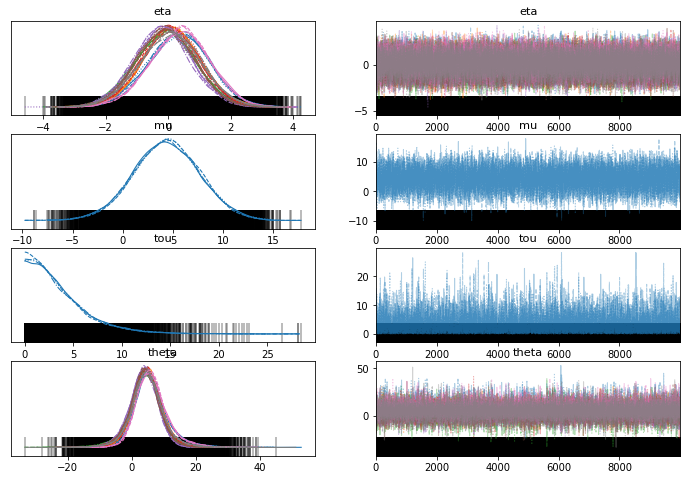

In [35]:
az.plot_trace(trace_noncentered);

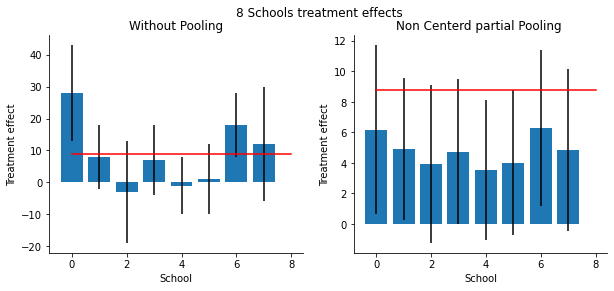

In [53]:
burnin = 300
# thetas = states_non_cent.position['eta']*jnp.mean(states_non_cent.position['tou'][burnin:])+jnp.mean(states_non_cent.position['mu'][burnin:])
thetas = states_non_cent.position["theta"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
ax2.bar(
    range(num_schools),
    jnp.mean(jnp.mean(thetas[burnin:, :], axis=0), axis=0),
    yerr=jnp.mean(jnp.std(thetas[burnin:, :], axis=0), axis=0),
)
ax1.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax2.plot([0, 8], [treatment_effects.mean(), treatment_effects.mean()], color="r", label="global mean")
ax1.set_xlabel("School")
ax1.set_ylabel("Treatment effect")
ax1.set_title("Without Pooling")
ax2.set_title("Non Centerd partial Pooling ")
sns.despine()
plt.suptitle("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
plt.show()

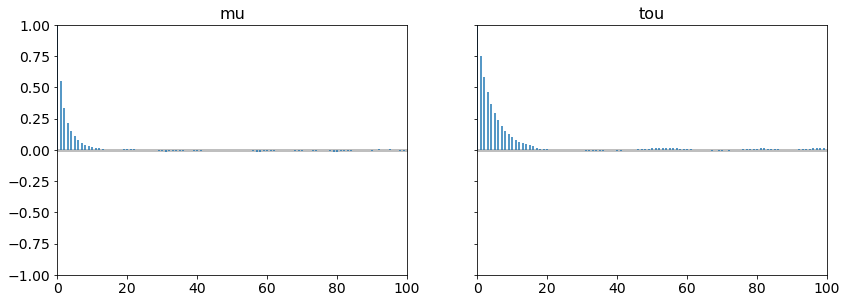

In [37]:
# with NonCentered_eight:
az.plot_autocorr(trace_noncentered, var_names=["mu", "tou"], combined=True)
plt.savefig("schools8_noncentered_acf_combined.png", dpi=300)

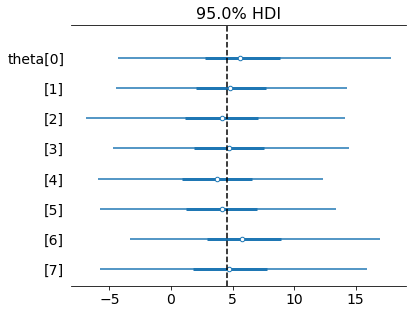

In [54]:
# with NonCentered_eight:
az.plot_forest(trace_noncentered, var_names="theta", combined=True, hdi_prob=0.95)
plt.axvline(jnp.mean(states_cent.position["theta"].mean()), color="k", linestyle="--")
plt.savefig("schools8_noncentered_forest_combined.png", dpi=300)

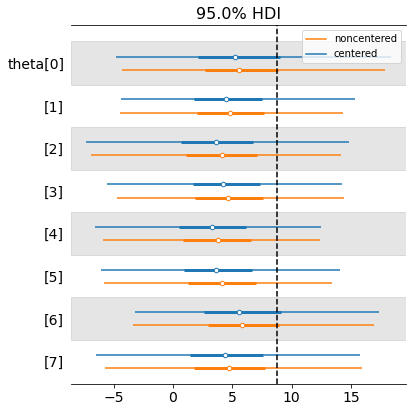

In [57]:
from cProfile import label


az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names="theta",
    combined=True,
    hdi_prob=0.95,
)
plt.axvline(jnp.mean(treatment_effects), color="k", linestyle="--")

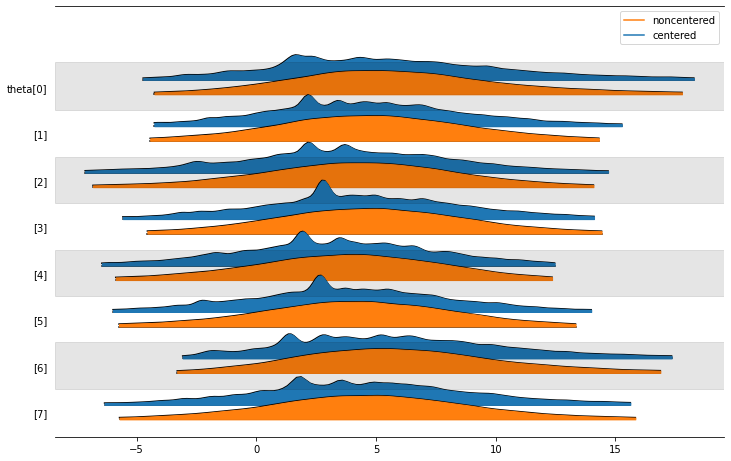

In [40]:
az.plot_forest(
    [trace_centered, trace_noncentered],
    model_names=["centered", "noncentered"],
    var_names=["theta"],
    kind="ridgeplot",
    combined=True,
    hdi_prob=0.95,
);

# Funnel of hell

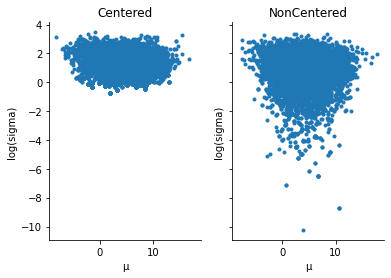

In [59]:
# Plot the "funnel of hell"
# Based on
# https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb

fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(states_cent.position["mu"][:, 0], name="mu")
y = pd.Series(jnp.log(states_cent.position["tou"][:, 0].flatten()), name="log_sigma")
axs[0].plot(x, y, ".")
axs[0].set(title="Centered", xlabel="µ", ylabel="log(sigma)")
# axs[0].axhline(0.01)

x = pd.Series(states_non_cent.position["mu"][:, 0].flatten(), name="mu")
y = pd.Series(jnp.log(states_non_cent.position["tou"][:, 0].flatten()), name="log_sigma")
axs[1].plot(x, y, ".")
axs[1].set(title="NonCentered", xlabel="µ", ylabel="log(sigma)")
# axs[1].axhline(0.01)

plt.savefig("schools8_funnel.png", dpi=300)
sns.despine()
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


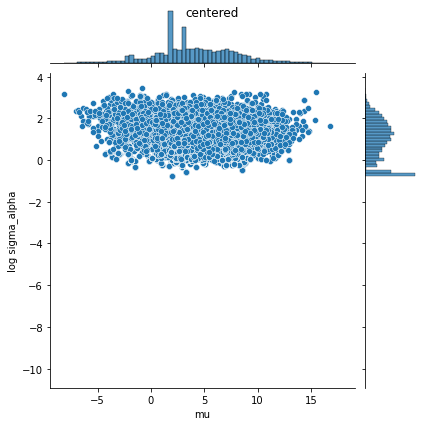

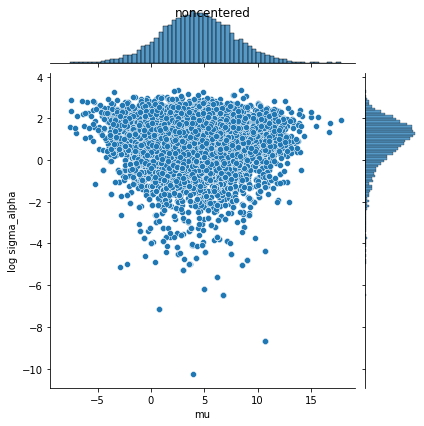

In [42]:
x = pd.Series(states_cent.position["mu"][:, 0], name="mu")
y = pd.Series(jnp.log(states_cent.position["tou"][:, 0]), name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("centered")
plt.savefig("schools8_centered_joint.png", dpi=300)

x = pd.Series(states_non_cent.position["mu"][:, 0], name="mu")
y = pd.Series(jnp.log(states_non_cent.position["tou"][:, 0]), name="log sigma_alpha")
sns.jointplot(x, y, xlim=xlim, ylim=ylim)
plt.suptitle("noncentered")
plt.savefig("schools8_noncentered_joint.png", dpi=300)

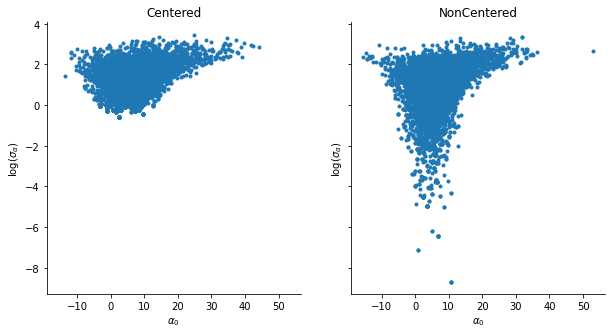

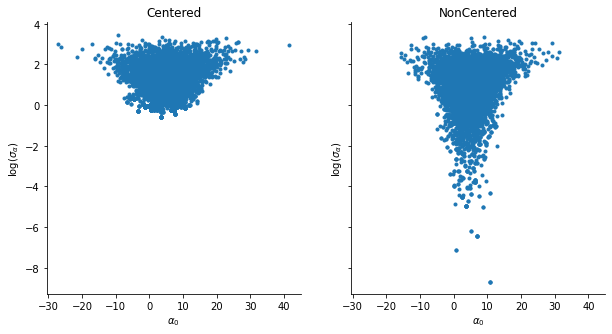

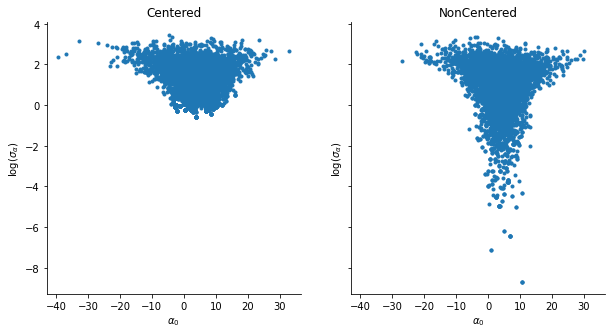

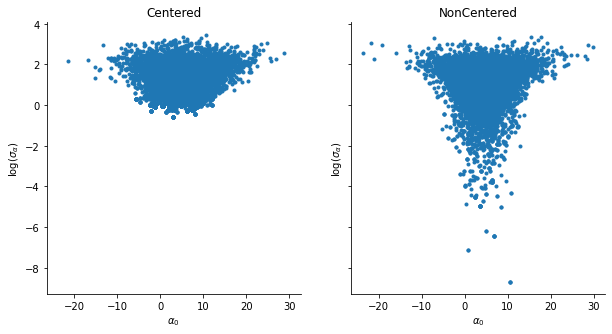

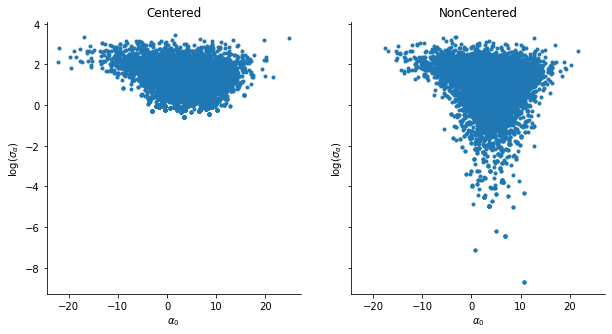

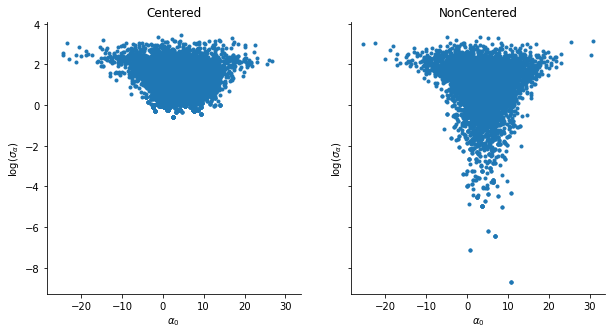

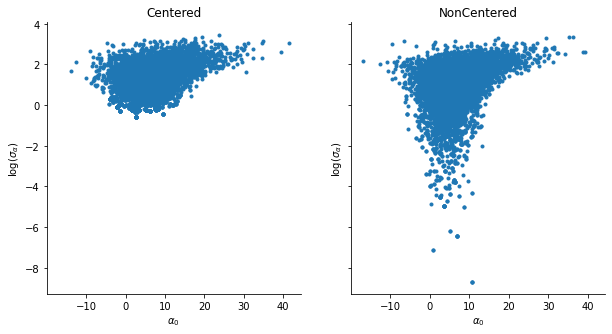

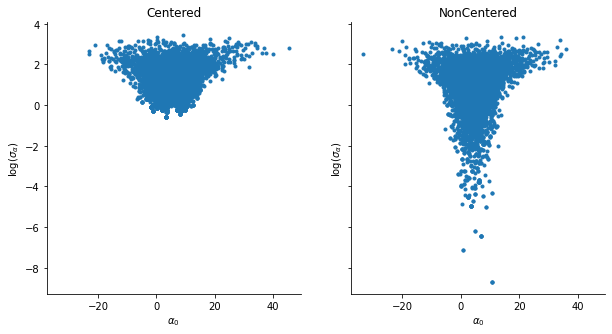

In [60]:
for group in range(8):
    burnin = num_samples // 4
    fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(10, 5))
    x = pd.Series(states_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
    y = pd.Series(jnp.log(states_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
    axs[0].plot(x, y, ".")
    axs[0].set(title="Centered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

    x = pd.Series(states_non_cent.position["theta"][burnin:, 0, group], name=f"alpha {group}")
    y = pd.Series(jnp.log(states_non_cent.position["tou"][burnin:, 0]), name="log_sigma_alpha")
    axs[1].plot(x, y, ".")
    axs[1].set(title="NonCentered", xlabel=r"$\alpha_0$", ylabel=r"$\log(\sigma_\alpha)$")

    xlim = axs[0].get_xlim()
    ylim = axs[0].get_ylim()
    sns.despine()
    plt.savefig(f"schools8_funnel_group{group}.png", dpi=300)
    plt.show()